In [82]:
import pandas as pd
import json
import os

json_files = {}

folder = "results_v2"
files = os.listdir(folder)


for file in files:
    with open(folder+"/"+file, "r") as f:
        df = pd.DataFrame(json.load(f))
        json_files[file] = df

folder = "results_delta_2025-06-28"
files = os.listdir(folder)


for file in files:
    with open(folder+"/"+file, "r") as f:
        df = pd.DataFrame(json.load(f))
        json_files[file] = df

folder = "results"
files = os.listdir(folder)


for file in files:
    if file[-4:] != "json":
        continue
    with open(folder+"/"+file, "r") as f:
        df = pd.DataFrame(json.load(f))
        json_files[file] = df


df = pd.concat(json_files.values(), axis = 0)
df

,tensor_location,criterion_score,layer_name,value_before,value_after
0,"[0, 0, 349]",0.0896,class_token,0.015516,3.003372
0,"[192, 0, 20, 30]",0.7614,conv_proj.weight,0.000377,0.684720
0,[376],0.7580,conv_proj.bias,0.016747,1.180125
0,"[0, 4, 201]",0.7608,encoder.pos_embedding,0.003855,-1.331274
0,"[0, 0, 28]",0.0670,class_token,-0.000617,12.727129
...,...,...,...,...,...
1515,[629],0.7608,heads.head.bias,-0.010798,-0.172764
1516,[64],0.7608,heads.head.bias,-0.012882,-0.206115
1517,[105],0.7608,heads.head.bias,-0.028462,-0.455388
1518,[175],0.7608,heads.head.bias,-0.051129,-0.818071


In [83]:
df.dtypes

tensor_location     object
criterion_score    float64
layer_name          object
value_before       float64
value_after        float64
dtype: object

In [84]:
from math import log10, floor
def round_to_1(x):
    return round(x, -int(floor(log10(abs(x)))))

def round_to_nearest_power_of_10_str(num):
    if num == 0:
        return "0e0"
    if abs(num) > 1e32:
        return ">1e32"
    exponent = round(log10(abs(num)))
    return f"1e{exponent}"

df['tensor_location'] = df['tensor_location'].astype(str).astype('|S') # which will by default set the length to the max len it encounters
df['layer_name'] = df['layer_name'].astype('|S') # which will by default set the length to the max len it encounters
df['delta_val'] = (df['value_after'] - df["value_before"])
df['delta_val'] = df["delta_val"].abs()
df['delta'] = df['delta_val'].apply(round_to_nearest_power_of_10_str).astype('|S')
df.dtypes

tensor_location       |S16
criterion_score    float64
layer_name            |S62
value_before       float64
value_after        float64
delta_val          float64
delta                  |S5
dtype: object

In [85]:
df = df.sort_values(by = ["layer_name", "delta", "tensor_location", "criterion_score"]).reset_index(drop = True).sort_values(by = "delta_val")
df

,tensor_location,criterion_score,layer_name,value_before,value_after,delta_val,delta
207,"b'[0, 0, 368]'",0.7608,b'class_token',-0.000005,-5.263775e-06,4.656613e-10,b'1e-9'
23608,b'[405]',0.7608,b'encoder.layers.encoder_layer_5.ln_2.bias',-0.000006,-5.738550e-06,4.656613e-10,b'1e-9'
4770,b'[734]',0.7608,b'encoder.layers.encoder_layer_1.ln_2.bias',-0.000004,-4.019697e-06,4.656613e-10,b'1e-9'
16802,b'[114]',0.7608,b'encoder.layers.encoder_layer_3.ln_1.bias',0.000015,1.497712e-05,9.313226e-10,b'1e-9'
29380,b'[283]',0.7608,b'encoder.layers.encoder_layer_7.ln_1.bias',0.000008,8.255776e-06,9.313226e-10,b'1e-9'
...,...,...,...,...,...,...,...
39083,b'[605]',0.0018,b'encoder.ln.weight',0.826756,2.813306e+38,2.813306e+38,b'>1e32'
39062,b'[180]',0.0010,b'encoder.ln.weight',0.835171,2.841939e+38,2.841939e+38,b'>1e32'
39065,b'[207]',0.0010,b'encoder.ln.weight',0.857950,2.919451e+38,2.919451e+38,b'>1e32'
39089,b'[756]',0.0010,b'encoder.ln.weight',0.863605,2.938697e+38,2.938697e+38,b'>1e32'


<Axes: xlabel='delta', ylabel='criterion_score'>

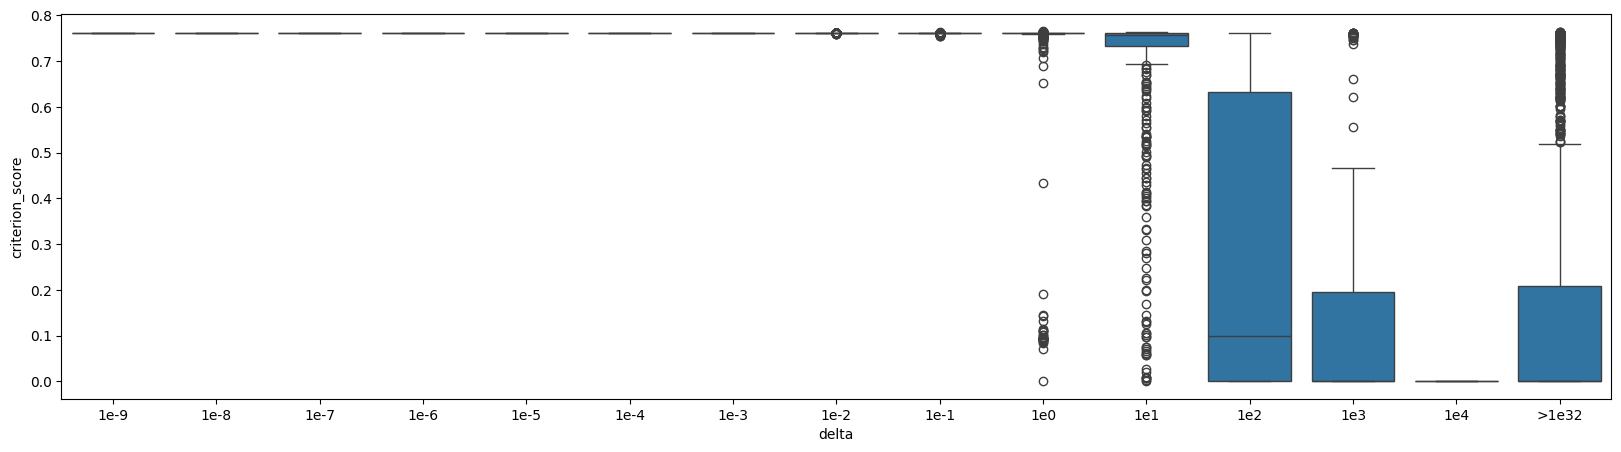

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
sns.boxplot(data = df, x = "delta", y = "criterion_score")

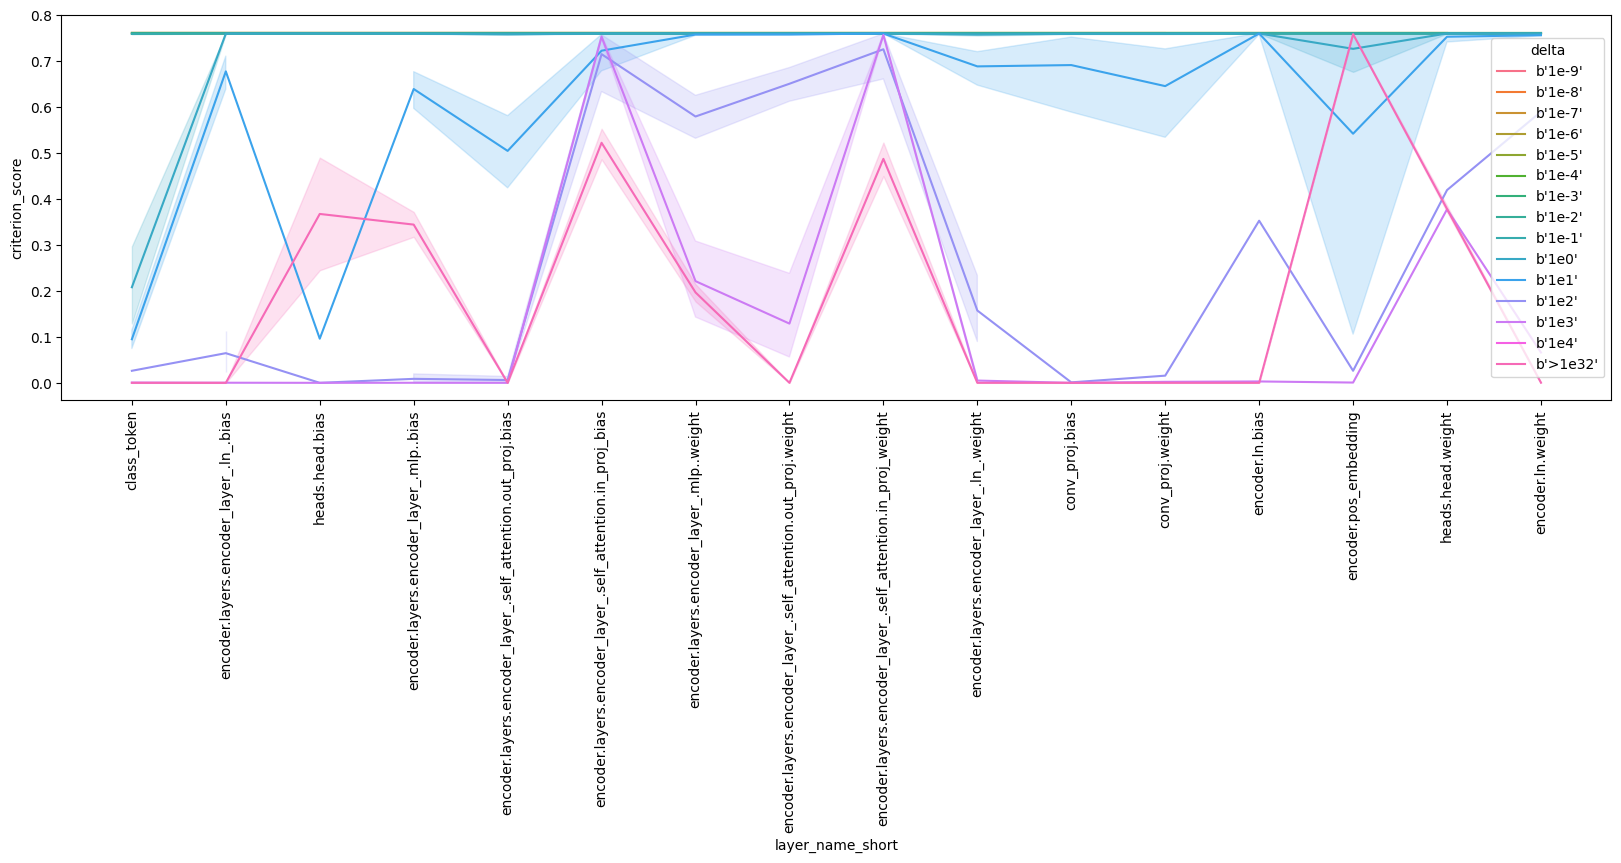

In [87]:
import matplotlib.pyplot as plt

df["layer_name_short"] = df["layer_name"].apply(lambda x: x.decode() if isinstance(x, bytes) else x).str.replace(r'\d+', '', regex=True)


plt.figure(figsize=(20,5))
sns.lineplot(data = df, x = "layer_name_short", y = "criterion_score", hue = "delta")
plt.xticks(rotation = 90)
plt.show()

In [88]:
df["delta"].value_counts()

C:\Users\wwden\AppData\Local\Temp\ipykernel_7444\857499797.py:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  df["delta"].value_counts()


delta
b'1e-2'     8445
b'1e-1'     6236
b'1e0'      5273
b'1e-3'     4836
b'>1e32'    4712
b'1e-4'     3036
b'1e-5'     2935
b'1e-6'     2351
b'1e-7'      902
b'1e1'       533
b'1e-8'      261
b'1e2'       191
b'1e3'       154
b'1e-9'       22
b'1e4'         1
Name: count, dtype: int64

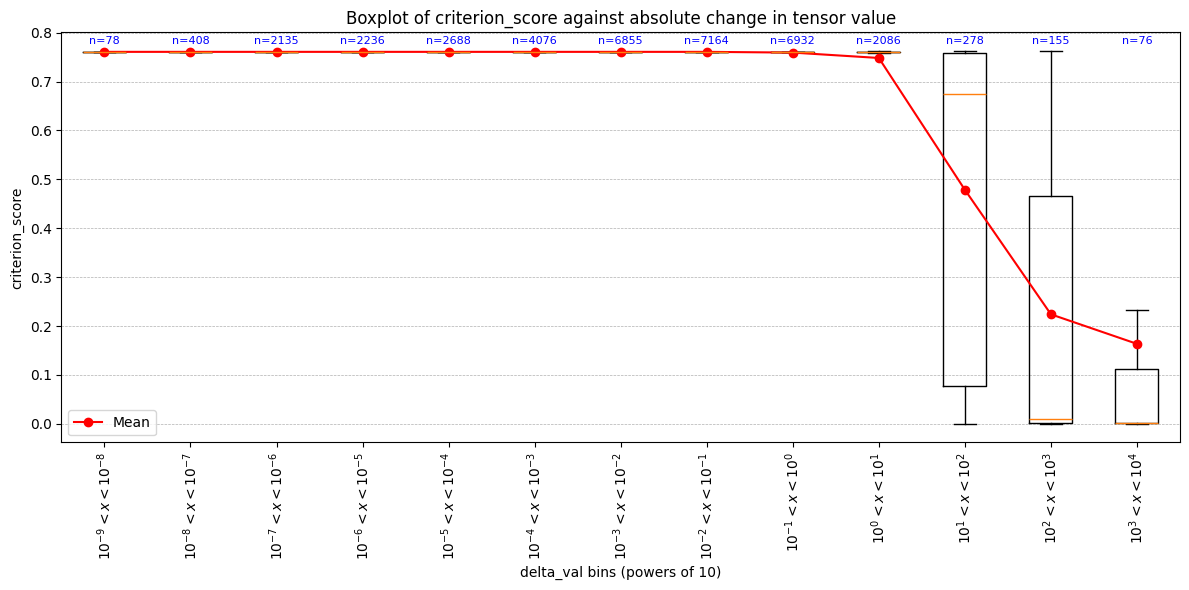

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

bin_edges = np.logspace(-9, 4, num=14)
df['delta_bin'] = pd.cut(df['delta_val'], bins=bin_edges, right=False)
groups = [df.loc[df['delta_bin'] == interval, 'criterion_score'].values for interval in df['delta_bin'].cat.categories]

means = [grp.mean() if len(grp) > 0 else np.nan for grp in groups]
mean_delta_vals = [df.loc[df['delta_bin'] == interval, 'delta_val'].mean() for interval in df['delta_bin'].cat.categories]

labels = [f"$10^{{{int(np.log10(interval.left))}}} < x < 10^{{{int(np.log10(interval.right))}}}$" 
          for interval in df['delta_bin'].cat.categories]

counts = [len(grp) for grp in groups]

fig, ax = plt.subplots(figsize=(12, 6))

box = ax.boxplot(groups, positions=range(1, len(groups)+1), showfliers=False)
ax.plot(range(1, len(means)+1), means, marker='o', color='red', linestyle='-', label='Mean')

ax.set_xticks(range(1, len(labels)+1))
ax.set_xticklabels(labels, rotation=90)
ax.set_xlabel('delta_val bins (powers of 10)')
ax.set_ylabel('criterion_score')
ax.set_title('Boxplot of criterion_score against absolute change in tensor value')

# Add sample counts above each boxplot
for i, count in enumerate(counts, start=1):
    ax.text(i, ax.get_ylim()[1] - 0.027, f'n={count}', ha='center', va='bottom', fontsize=8, color='blue')

ax.grid(axis='y', linestyle='--', linewidth=0.5)
ax.legend()
plt.tight_layout()
plt.show()



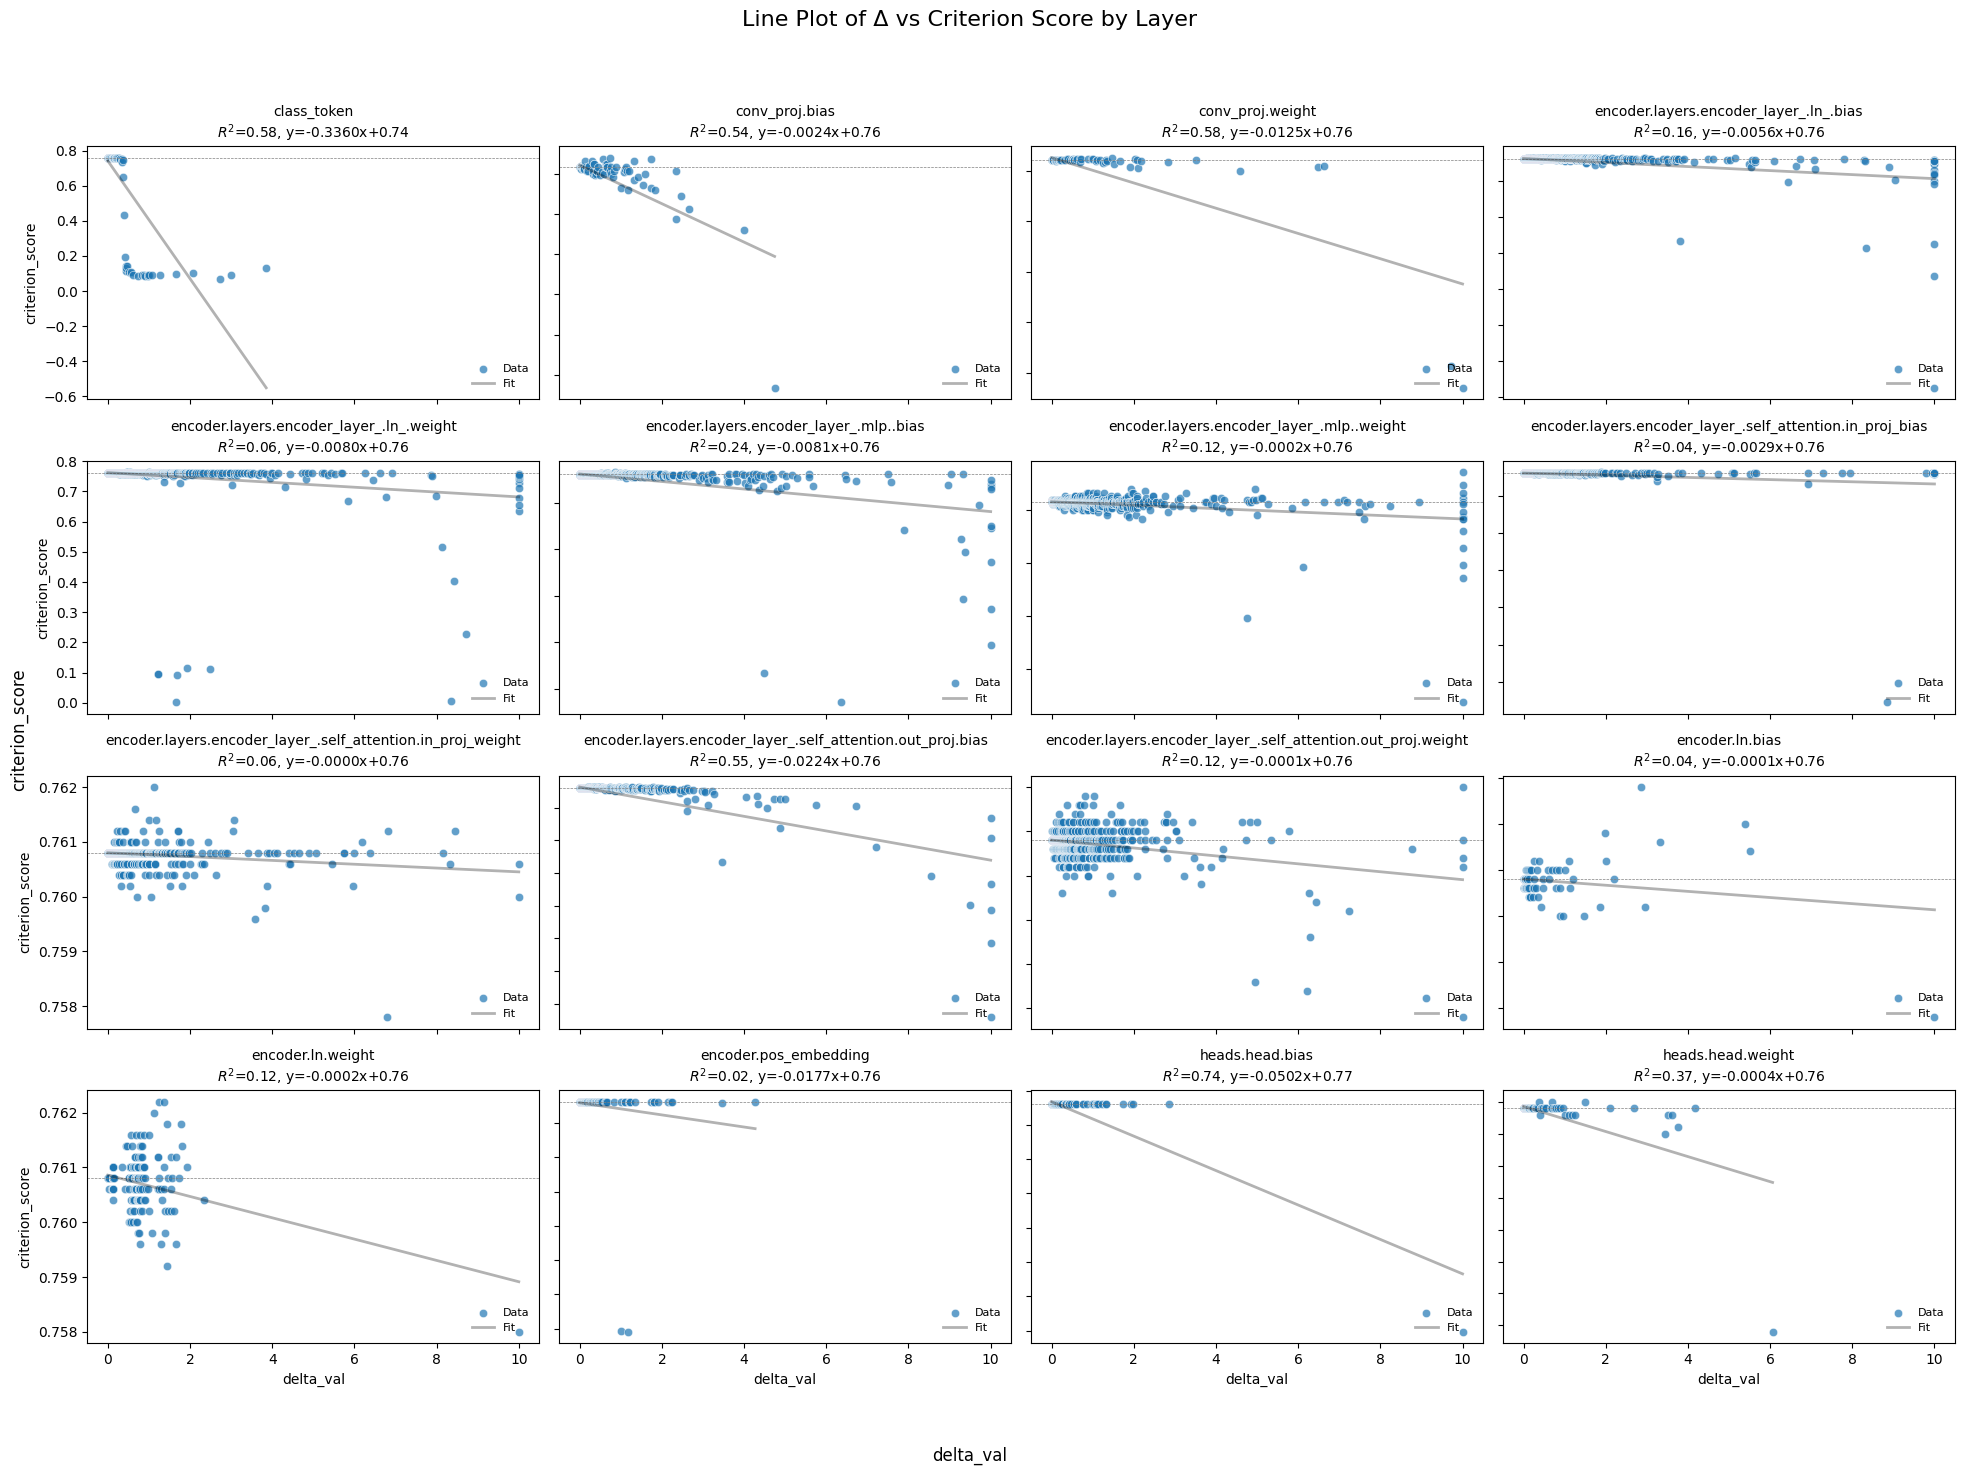

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Filter data
df = df[df["delta_val"] < 10]

# Get sorted unique layer names
layer_names = sorted(df["layer_name_short"].unique())
n_layers = len(layer_names)
n_cols = 4
n_rows = int(np.ceil(n_layers / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15), sharex=True, sharey=False)
axes = axes.flatten()

for i, layer in enumerate(layer_names):
    ax = axes[i]
    subset = df[df["layer_name_short"] == layer]
    if subset.empty:
        continue

    # Sort by delta_val
    subset = subset.sort_values("delta_val")
    ax.axhline(y=0.7608, color='gray', linestyle='--', linewidth=0.5)
    X = subset["delta_val"].values.reshape(-1, 1)
    y = subset["criterion_score"].values

    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    r2 = r2_score(y, y_pred)
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # Line plot of the actual data
    #sns.lineplot(x=subset["delta_val"], y=subset["criterion_score"], ax=ax, label="Data", alpha=0.7)
    sns.scatterplot(x=subset["delta_val"], y=subset["criterion_score"], ax=ax, label="Data", alpha=0.7)

    # Regression line
    sns.lineplot(x=subset["delta_val"], y=y_pred, ax=ax, color='black', linewidth=2, label="Fit", alpha = 0.3)

    ax.set_title(f"{layer}\n$R^2$={r2:.2f}, y={slope:.4f}x+{intercept:.2f}", fontsize=10)
    ax.label_outer()
    ax.legend(fontsize=8, loc="lower right", frameon=False)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Line Plot of Δ vs Criterion Score by Layer", fontsize=16)
fig.supxlabel("delta_val")
fig.supylabel("criterion_score")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


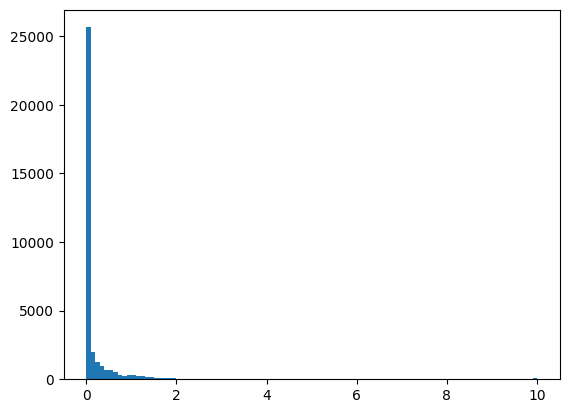

In [91]:
plt.hist(df["delta_val"], bins = 100)
plt.show()